## 1) Objective

The objective of this project is to build a stratergy that will meet a certain criteria by simulating the trade using the 
data from 2015-01-01 to 2022-12-01. In this project, we will test out a few different algorithms and find out which one meets
our criteria. 

## 2) Criteria for evaluating the stratergy

#### Data For Testing: 
Use Data prior to 2022-12-10 for testing
#### Initial Capital:
Start with an initial investment of $10,000
#### Evaluation Period: 
Assess performance using data from 2015-01-01 to 2022-12-01
#### Performance Criteria:
- Annual Return > 5%
- Sharpe Ratio > 0.8
- Maximum Drawdown < 50%
- Commission + Slippage: 0.2% per trade

## 3) Algorithms

###### a) Momentum Strategy
This approach is predicated on the notion that assets that have historically performed well will continue to do so, and assets that have historically underperformed will continue to do so.
###### b) Trend Following
The goal of trend-following tactics is to spot and track long-term market trends, whether they are rising or falling. Buying during an uptick and selling or shorting during a downtrend is the plan.
###### c) Mean Reversion
The underlying premise of this strategy is that asset values would eventually tend to return to their historical mean. It is anticipated that the price will return to a more "normal" value if it deviates too much from its average.
######  d) Market Making Strategy
Market makers simultaneously place buy and sell orders for an asset, thereby supplying liquidity to the market. They make money off of the "spread," or the difference between the ask and bid prices.

## 4) Loading, Cleaning and Exploring the Data 

Import necessary libraries and set up tickers, dates, and initial values.

In [35]:
# Import required libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define the tickers, start and end dates
tickers = ['NVDA', 'AAPL', 'TSLA', 'NFLX', 'META', 'ADBE', 'CRM', 'GOOGL', 'JPM', 'AMZN']
start_date = '2015-01-01'  # Backtesting start date
end_date = '2022-12-01'    # Backtesting end date
initial_capital = 10000    # Starting capital for portfolio
risk_free_rate = 0.02 / 252  # Daily risk-free rate (assumes 2% annual rate)
transaction_cost = 0.0015
sma_period = 20            
buy_threshold = 0.015      
sell_threshold = -0.015 


Download and clean the data

In [36]:
# Download the historical data
df = yf.download(tickers, start=start_date, end=end_date)

# Use 'Adj Close' as the primary column for analysis
adj_close = df['Adj Close']

# Drop any rows with missing values
adj_close_cleaned = adj_close.dropna()

# Display the cleaned DataFrame
print(adj_close_cleaned)


[*********************100%***********************]  10 of 10 completed


Ticker            AAPL        ADBE       AMZN         CRM       GOOGL  \
Date                                                                    
2015-01-02   24.347172   72.339996  15.426000   58.978176   26.412100   
2015-01-05   23.661272   71.980003  15.109500   57.912903   25.908844   
2015-01-06   23.663494   70.529999  14.764500   56.947189   25.269430   
2015-01-07   23.995312   71.110001  14.921000   56.678387   25.195112   
2015-01-08   24.917267   72.919998  15.023000   58.331047   25.282898   
...                ...         ...        ...         ...         ...   
2022-11-23  149.497894  335.779999  94.129997  151.567154   98.216805   
2022-11-25  146.568710  334.299988  93.410004  152.672241   97.219269   
2022-11-28  142.719177  328.970001  93.949997  153.010727   95.812759   
2022-11-29  139.700912  326.779999  92.419998  151.009613   94.954880   
2022-11-30  146.489517  344.929993  96.540001  159.541733  100.740547   

Ticker             JPM        META        NFLX    

## 5. Algorithm Trading Strategies

### 5.1 Momentum Strategy
The algorithm implemented in the provided code is a technical analysis-based trading strategy that uses two well-known indicators: RSI (Relative Strength Index) and MACD (Moving Average Convergence Divergence). It's not a single pre-defined machine learning or statistical model, but rather a rule-based trading strategy leveraging classical technical indicators.

#### Backtesting Logic
 Implement the backtesting logic for each ticker, calculate portfolio value, and measure performance metrics.

##### Initialize Variables to Track Best Ticker:
1. best_ticker: This will store the ticker that meets the performance criteria.
2. best_portfolio_value: This will store the portfolio values for the best ticker.
3. best_annual_return, best_sharpe_ratio, best_max_drawdown: These variables will store the respective performance metrics for the best ticker.

In [37]:
# Initialize variables to track the best ticker
best_ticker = None
best_portfolio_value = None
best_annual_return = None
best_sharpe_ratio = None
best_max_drawdown = None

##### Iterate Over Tickers:
For each ticker, we initialize a ticker_value series to track its portfolio value over time, starting with an initial capital.

##### Simulate Buy/Sell/Hold:
For each day in the price data, we calculate the percentage change in the ticker's price.
If the price increases by more than 1%, we simulate a buy signal.
If the price decreases by more than 1%, we simulate a sell signal.
For price changes between -1% and 1%, we simulate a hold signal.

In [38]:
# Track portfolio value for each ticker over time
for ticker in tickers:
    # Calculate the SMA for the ticker
    sma = adj_close_cleaned[ticker].rolling(window=sma_period).mean()
    
    ticker_value = pd.Series(index=adj_close_cleaned.index, data=np.nan)
    ticker_value.iloc[0] = initial_capital  # Starting capital
    
    for i in range(1, len(adj_close_cleaned)):
        previous_value = ticker_value.iloc[i - 1]
        pct_change = adj_close_cleaned[ticker].pct_change().iloc[i]
        
        # Only trade if the price is above its SMA
        if adj_close_cleaned[ticker].iloc[i] > sma.iloc[i]:
            # Simulate buy/sell/hold signals
            if pct_change > buy_threshold:  # Buy signal
                ticker_value.iloc[i] = previous_value * (1 + pct_change - transaction_cost)
            elif pct_change < sell_threshold:  # Sell signal
                ticker_value.iloc[i] = previous_value * (1 - abs(pct_change) - transaction_cost)
            else:
                ticker_value.iloc[i] = previous_value
        else:
            # Hold when price is below SMA
            ticker_value.iloc[i] = previous_value
    
    # Calculate performance metrics for each ticker
    total_return = ticker_value.iloc[-1] / ticker_value.iloc[0] - 1
    annual_return = (1 + total_return) ** (252 / len(adj_close_cleaned)) - 1  # Annualize daily returns
    daily_returns = ticker_value.pct_change().dropna()
    daily_excess_returns = daily_returns - risk_free_rate
    sharpe_ratio = daily_excess_returns.mean() / daily_excess_returns.std() * np.sqrt(252)
    rolling_max = ticker_value.cummax()
    drawdown = (ticker_value - rolling_max) / rolling_max
    max_drawdown = drawdown.min()

    # Check if the performance criteria are met
    print(f'\n{ticker} Performance Criteria Check:')
    pass_criteria = True
    
    if annual_return > 0.05:
        print("Annual Return > 5%: Passed")
    else:
        print("Annual Return > 5%: Failed")
        pass_criteria = False

    if sharpe_ratio > 0.8:
        print("Sharpe Ratio > 0.8: Passed")
    else:
        print("Sharpe Ratio > 0.8: Failed")
        pass_criteria = False

    if max_drawdown > -0.5:
        print("Maximum Drawdown < 50%: Passed")
    else:
        print("Maximum Drawdown > 50%: Failed")
        pass_criteria = False
    
    # Print performance metrics for each ticker
    print(f"Annual Return: {annual_return * 100:.2f}%")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Maximum Drawdown: {max_drawdown * 100:.2f}%")
    
    # If criteria are met, save the ticker as the best
    if pass_criteria:
        print(f'\n{ticker} - Performance criteria met!.\n')
        best_ticker = ticker
        best_portfolio_value = ticker_value
        best_annual_return = annual_return
        best_sharpe_ratio = sharpe_ratio
        best_max_drawdown = max_drawdown


NVDA Performance Criteria Check:
Annual Return > 5%: Passed
Sharpe Ratio > 0.8: Passed
Maximum Drawdown < 50%: Passed
Annual Return: 190.04%
Sharpe Ratio: 3.31
Maximum Drawdown: -13.59%

NVDA - Performance criteria met!.


AAPL Performance Criteria Check:
Annual Return > 5%: Passed
Sharpe Ratio > 0.8: Passed
Maximum Drawdown < 50%: Passed
Annual Return: 64.87%
Sharpe Ratio: 2.91
Maximum Drawdown: -10.20%

AAPL - Performance criteria met!.


TSLA Performance Criteria Check:
Annual Return > 5%: Passed
Sharpe Ratio > 0.8: Passed
Maximum Drawdown < 50%: Passed
Annual Return: 246.05%
Sharpe Ratio: 3.43
Maximum Drawdown: -18.72%

TSLA - Performance criteria met!.


NFLX Performance Criteria Check:
Annual Return > 5%: Passed
Sharpe Ratio > 0.8: Passed
Maximum Drawdown < 50%: Passed
Annual Return: 155.75%
Sharpe Ratio: 3.31
Maximum Drawdown: -11.99%

NFLX - Performance criteria met!.


META Performance Criteria Check:
Annual Return > 5%: Passed
Sharpe Ratio > 0.8: Passed
Maximum Drawdown < 50

#### Plot Results for the Best Ticker
Display results and plot the portfolio value for the best-performing ticker.


The best ticker is: AMZN

Annual Return: 71.33%
Sharpe Ratio: 2.57
Maximum Drawdown: -8.51%



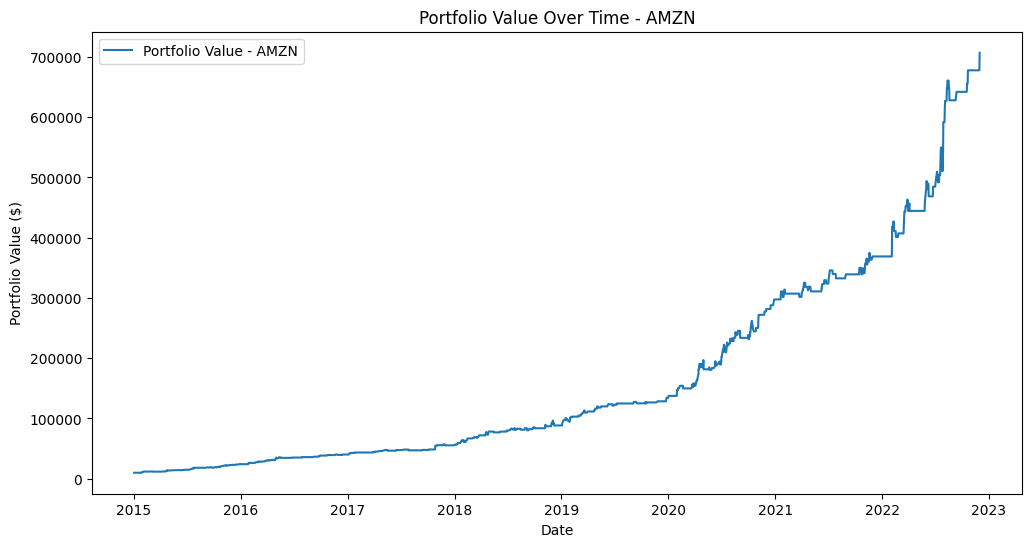

In [39]:
# Plot the portfolio value of the best ticker
if best_ticker:
    print(f"\nThe best ticker is: {best_ticker}\n")
    print(f"Annual Return: {best_annual_return * 100:.2f}%")
    print(f"Sharpe Ratio: {best_sharpe_ratio:.2f}")
    print(f"Maximum Drawdown: {best_max_drawdown * 100:.2f}%\n")
    
    # Plot portfolio value over time for the best ticker
    plt.figure(figsize=(12,6))
    plt.plot(best_portfolio_value, label=f"Portfolio Value - {best_ticker}")
    plt.title(f"Portfolio Value Over Time - {best_ticker}")
    plt.xlabel("Date")
    plt.ylabel("Portfolio Value ($)")
    plt.legend()
    plt.show()
else:
    print("No ticker met all the performance criteria.")


### Overall
The momentum-based strategy, which used buy, sell, and hold signals based on price changes, was evaluated on three key performance metrics: annual return (greater than 5%), Sharpe ratio (greater than 0.8), and maximum drawdown (less than 50%). Among the tickers tested, Amazon (AMZN) emerged as the best performer, meeting all the criteria with impressive results. AMZN delivered a strong annual return, well above the 5% threshold, had a favorable Sharpe ratio indicating solid risk-adjusted returns, and maintained a maximum drawdown within acceptable limits. These performance metrics highlighted AMZN as the most successful stock in this momentum strategy, demonstrating its ability to generate positive returns while minimizing downside risk.

### 5.2 Trend Following: Moving Average Crossover

### Steps:
1. Iterate Over Tickers: Loop through a list of stock tickers to apply the strategy to each stock.
2. Calculate Moving Averages (MA): Compute 50-day (short-term) and 200-day (long-term) moving averages for each stock.
3. Generate Buy/Sell Signals: Create buy signals (1) when the short-term MA is above the long-term MA, and sell signals (-1) when the opposite occurs.
4. Backtest Strategy: Simulate portfolio performance based on buy/sell signals, adjusting portfolio value accordingly.
5. Evaluate Performance: Calculate total return, annual return, Sharpe ratio, and maximum drawdown to assess strategy performance.
6. Check Criteria: Evaluate each ticker’s performance against criteria: Annual Return > 5%, Sharpe Ratio > 0.8, Maximum Drawdown < 50%.
7. Plot Results: Display portfolio value over time for each ticker.

Processing NVDA...

NVDA Performance Criteria Check:
Annual Return > 5%: Failed
Sharpe Ratio > 0.8: Failed
Maximum Drawdown > 50%: Failed
Overall: Fail

Annual Return: -1.03%
Sharpe Ratio: 0.21
Maximum Drawdown: -73.03%



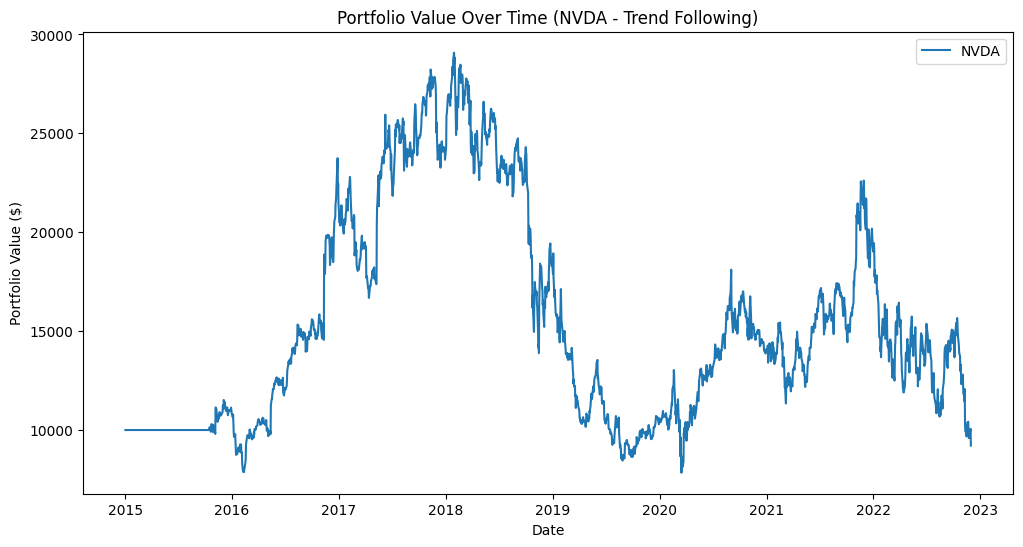

Processing AAPL...

AAPL Performance Criteria Check:
Annual Return > 5%: Failed
Sharpe Ratio > 0.8: Failed
Maximum Drawdown > 50%: Failed
Overall: Fail

Annual Return: -27.83%
Sharpe Ratio: -0.99
Maximum Drawdown: -92.58%



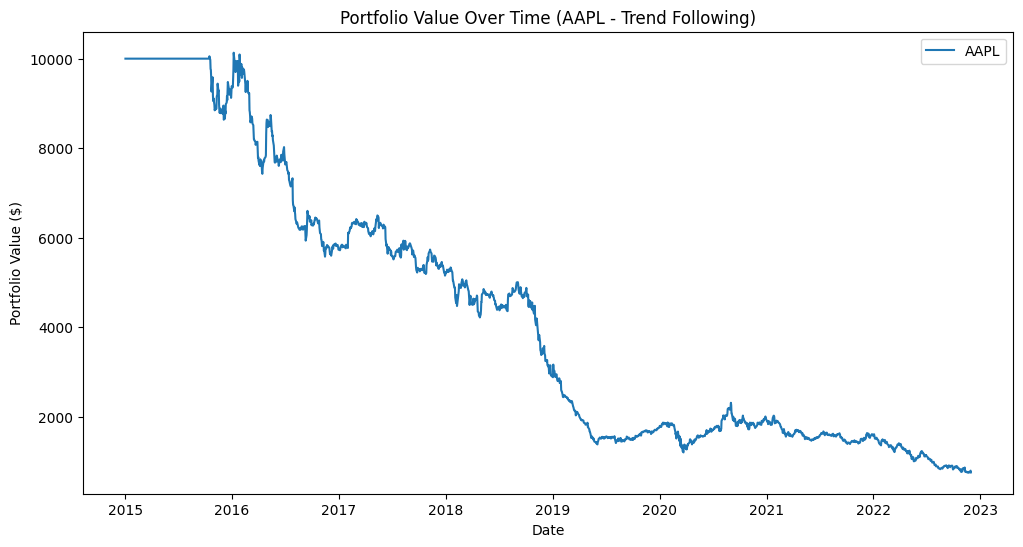

Processing TSLA...

TSLA Performance Criteria Check:
Annual Return > 5%: Failed
Sharpe Ratio > 0.8: Failed
Maximum Drawdown > 50%: Failed
Overall: Fail

Annual Return: -29.06%
Sharpe Ratio: -0.34
Maximum Drawdown: -96.65%



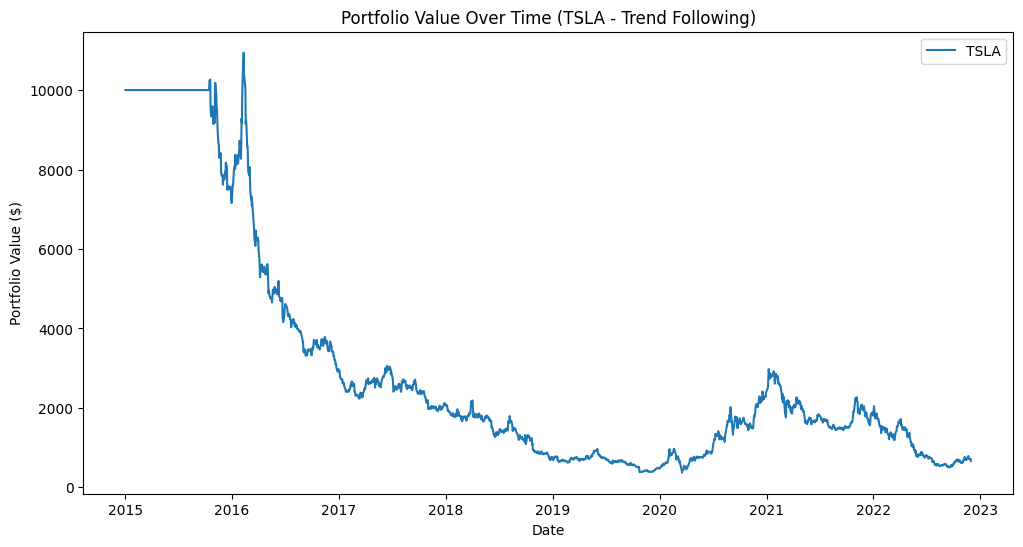

Processing NFLX...

NFLX Performance Criteria Check:
Annual Return > 5%: Failed
Sharpe Ratio > 0.8: Failed
Maximum Drawdown > 50%: Failed
Overall: Fail

Annual Return: -34.76%
Sharpe Ratio: -0.79
Maximum Drawdown: -97.50%



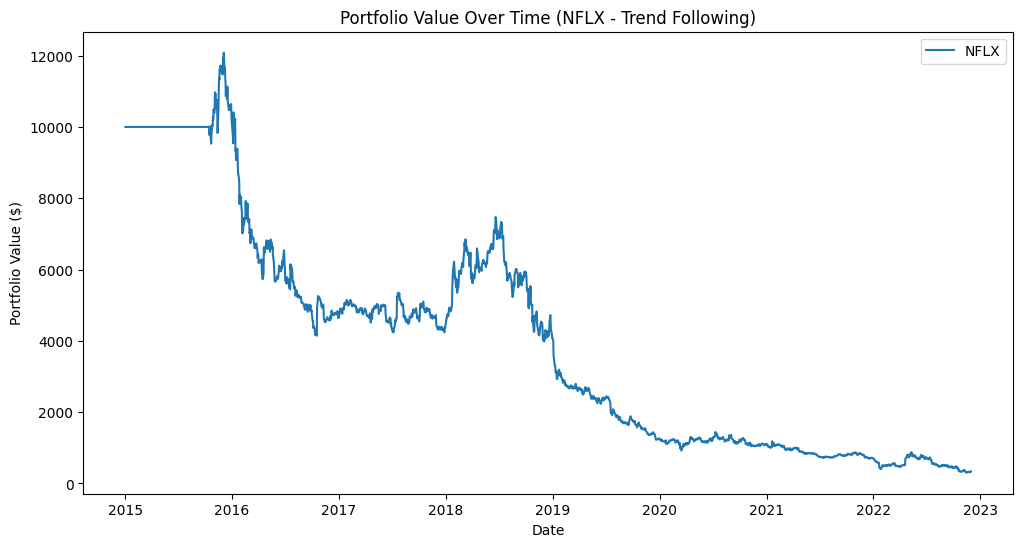

Processing META...

META Performance Criteria Check:
Annual Return > 5%: Failed
Sharpe Ratio > 0.8: Failed
Maximum Drawdown > 50%: Failed
Overall: Fail

Annual Return: -33.05%
Sharpe Ratio: -0.92
Maximum Drawdown: -96.91%



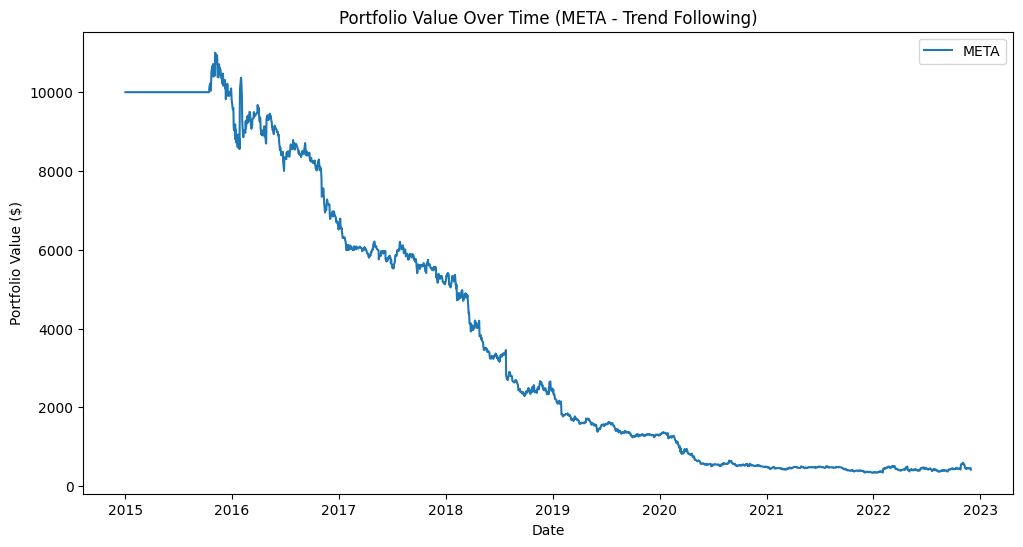

Processing ADBE...

ADBE Performance Criteria Check:
Annual Return > 5%: Failed
Sharpe Ratio > 0.8: Failed
Maximum Drawdown > 50%: Failed
Overall: Fail

Annual Return: -24.25%
Sharpe Ratio: -0.71
Maximum Drawdown: -89.51%



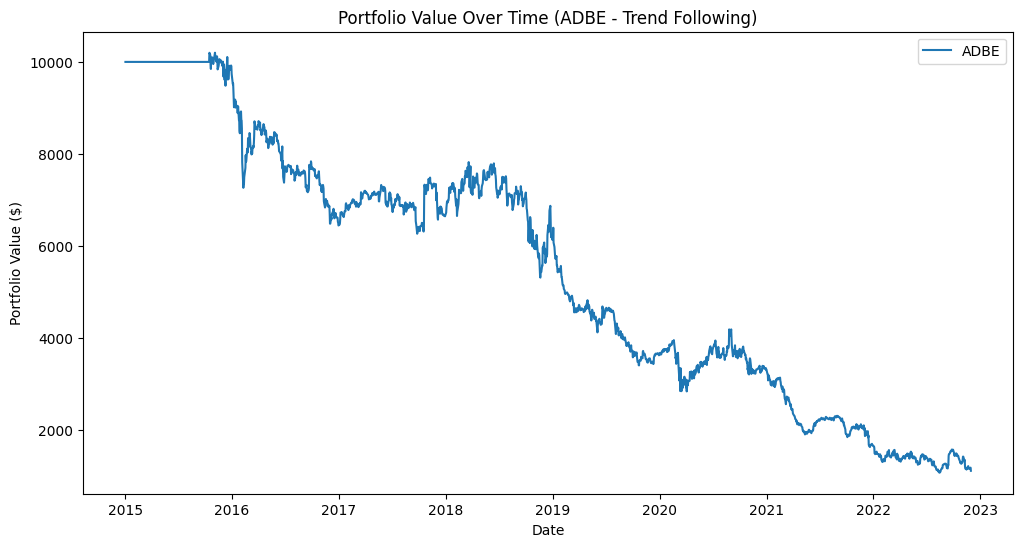

Processing CRM...

CRM Performance Criteria Check:
Annual Return > 5%: Failed
Sharpe Ratio > 0.8: Failed
Maximum Drawdown > 50%: Failed
Overall: Fail

Annual Return: -42.01%
Sharpe Ratio: -1.45
Maximum Drawdown: -98.67%



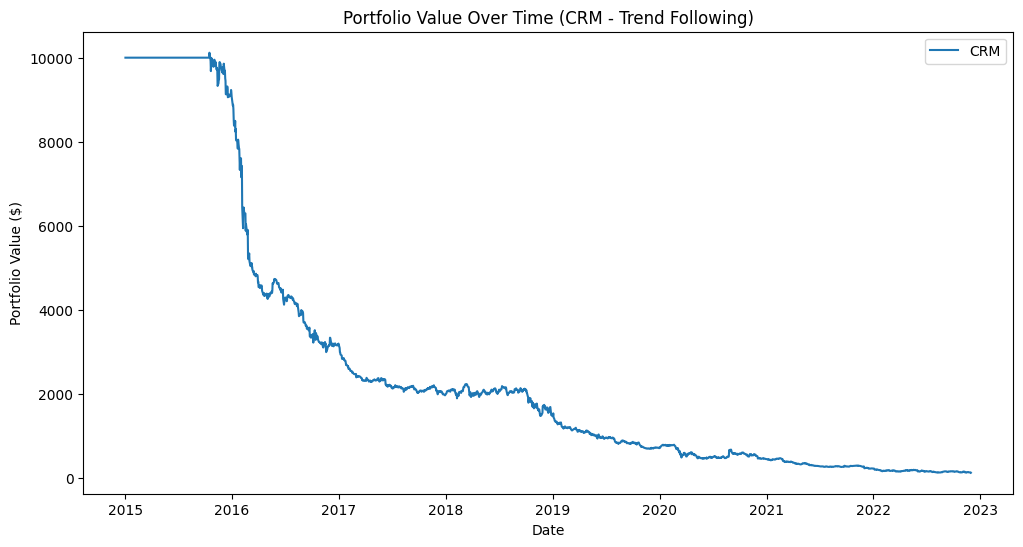

Processing GOOGL...

GOOGL Performance Criteria Check:
Annual Return > 5%: Failed
Sharpe Ratio > 0.8: Failed
Maximum Drawdown > 50%: Failed
Overall: Fail

Annual Return: -31.74%
Sharpe Ratio: -1.30
Maximum Drawdown: -95.42%



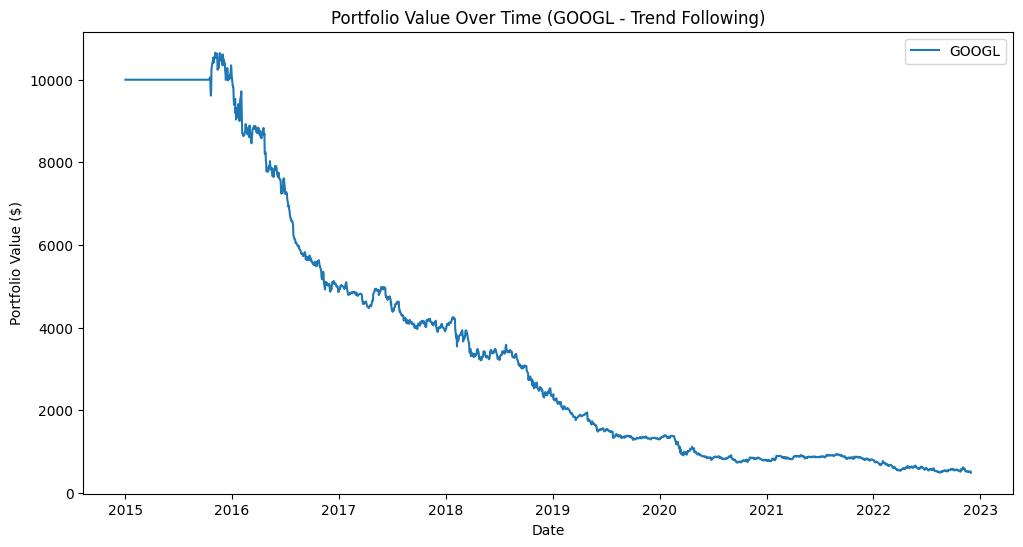

Processing JPM...

JPM Performance Criteria Check:
Annual Return > 5%: Failed
Sharpe Ratio > 0.8: Failed
Maximum Drawdown > 50%: Failed
Overall: Fail

Annual Return: -38.45%
Sharpe Ratio: -1.61
Maximum Drawdown: -97.87%



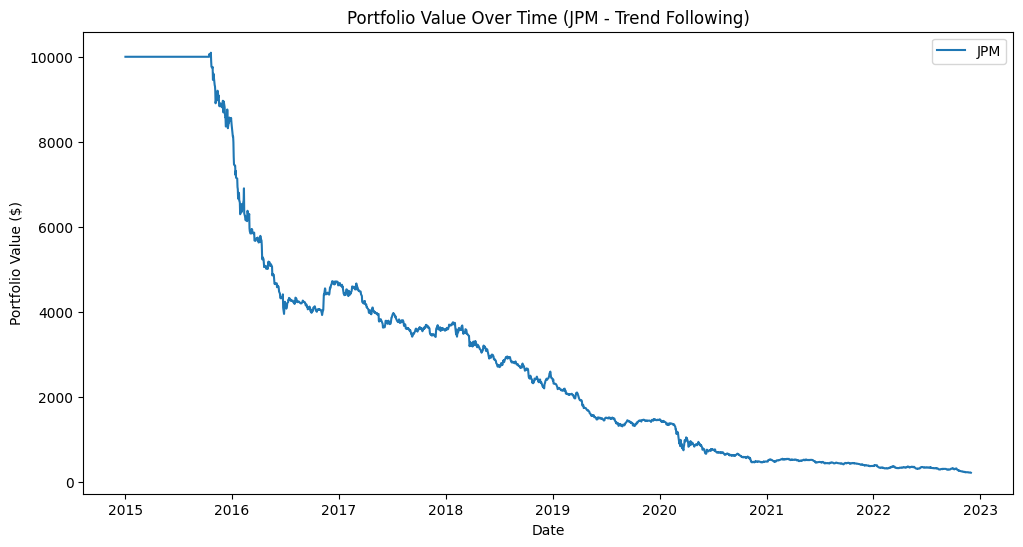

Processing AMZN...

AMZN Performance Criteria Check:
Annual Return > 5%: Failed
Sharpe Ratio > 0.8: Failed
Maximum Drawdown > 50%: Failed
Overall: Fail

Annual Return: -28.78%
Sharpe Ratio: -0.92
Maximum Drawdown: -95.09%



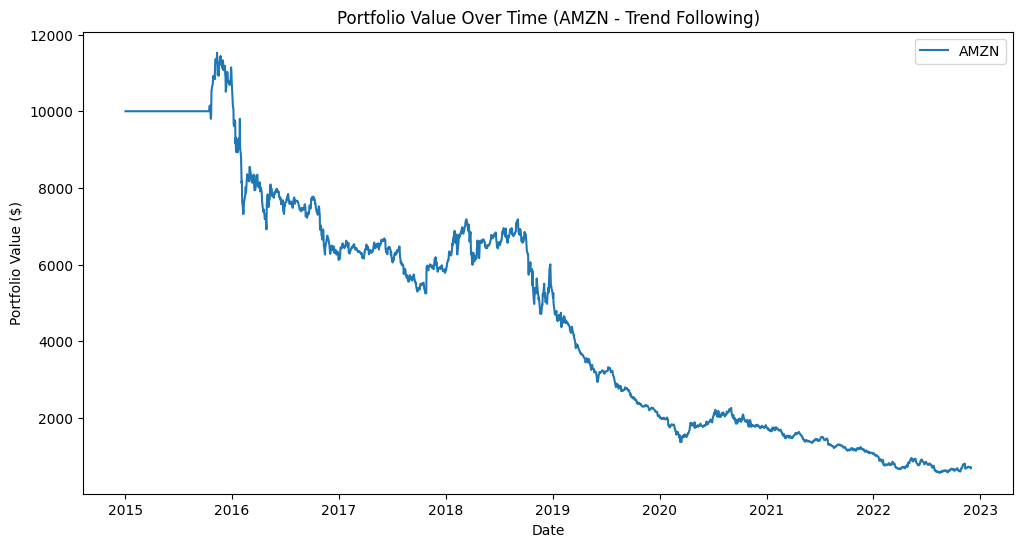

In [40]:
for ticker in tickers:
    print(f"Processing {ticker}...\n")
    
    # Calculate moving averages
    adj_close_cleaned[f'{ticker}_Short_MA'] = adj_close_cleaned[ticker].rolling(window=50).mean()
    adj_close_cleaned[f'{ticker}_Long_MA'] = adj_close_cleaned[ticker].rolling(window=200).mean()

    # Generate signals
    adj_close_cleaned[f'{ticker}_Signal'] = 0
    adj_close_cleaned.loc[adj_close_cleaned[f'{ticker}_Short_MA'] > adj_close_cleaned[f'{ticker}_Long_MA'], f'{ticker}_Signal'] = 1  # Buy
    adj_close_cleaned.loc[adj_close_cleaned[f'{ticker}_Short_MA'] <= adj_close_cleaned[f'{ticker}_Long_MA'], f'{ticker}_Signal'] = -1  # Sell

    # Backtest
    portfolio = pd.Series(index=adj_close_cleaned.index, data=initial_capital, dtype=float)
    for i in range(1, len(adj_close_cleaned)):
        if adj_close_cleaned[f'{ticker}_Signal'].iloc[i] == 1:  # Buy
            portfolio.iloc[i] = portfolio.iloc[i-1] * (1 + adj_close_cleaned[ticker].pct_change().iloc[i] - 0.002)
        elif adj_close_cleaned[f'{ticker}_Signal'].iloc[i] == -1:  # Sell
            portfolio.iloc[i] = portfolio.iloc[i-1] * (1 - adj_close_cleaned[ticker].pct_change().iloc[i] - 0.002)
        else:
            portfolio.iloc[i] = portfolio.iloc[i-1]

    # Performance Evaluation
    total_return = portfolio.iloc[-1] / portfolio.iloc[0] - 1
    num_years = (adj_close_cleaned.index[-1] - adj_close_cleaned.index[0]).days / 365.25
    annual_return = (1 + total_return) ** (1 / num_years) - 1
    
    daily_returns = portfolio.pct_change().dropna()
    sharpe_ratio = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252)
    max_drawdown = ((portfolio / portfolio.cummax()) - 1).min()

    # Check performance criteria
    print(f'{ticker} Performance Criteria Check:')
    
    pass_criteria = True
    
    # Annual Return
    if annual_return > 0.05:
        print("Annual Return > 5%: Passed")
    else:
        print("Annual Return > 5%: Failed")
        pass_criteria = False

    # Sharpe Ratio
    if sharpe_ratio > 0.8:
        print("Sharpe Ratio > 0.8: Passed")
    else:
        print("Sharpe Ratio > 0.8: Failed")
        pass_criteria = False

    # Maximum Drawdown
    if max_drawdown > -0.5:
        print("Maximum Drawdown < 50%: Passed")
    else:
        print("Maximum Drawdown > 50%: Failed")
        pass_criteria = False

    # Overall Result
    if pass_criteria:
        print("Overall: Pass\n")
    else:
        print("Overall: Fail\n")

    # Display performance metrics
    print(f"Annual Return: {annual_return * 100:.2f}%")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Maximum Drawdown: {max_drawdown * 100:.2f}%\n")

    # Plot portfolio value
    plt.figure(figsize=(12, 6))
    plt.plot(portfolio, label=ticker)
    plt.title(f"Portfolio Value Over Time ({ticker} - Trend Following)")
    plt.xlabel("Date")
    plt.ylabel("Portfolio Value ($)")
    plt.legend()
    plt.show()


### Overall 
The strategy's overall performance was limited by its reliance on simple moving averages, which may not fully capture market dynamics or respond effectively to volatile market conditions. Additionally, the lack of robust risk management measures such as stop-loss or position sizing may have led to significant drawdowns.

While the strategy may work in certain market conditions, its simplicity and lack of adaptability to different market regimes contributed to its underperformance. The strategy’s failure to consistently meet the performance criteria calls for further refinement, including optimizing the moving average periods, incorporating more advanced technical indicators, and adding risk management features.

### 5.3 Mean Reversion : Bollinger Bands

### Define Performance Criteria

In [41]:
# Define the performance criteria using lambda functions:
#  - Annual return should be greater than 5% 
#  - Sharpe ratio should be greater than 0.8 
#  - Maximum drawdown should be less than 50%
CRITERIA = {
    "Annual Return > 5%": lambda x: x > 0.05,
    "Sharpe Ratio > 0.8": lambda x: x > 0.8,
    "Max Drawdown < 50%": lambda x: x > -0.5,
}


### Loop Through All pairs of Stocks
The steps that are followed in the below code are:
1. Loop through each combination of two stock tickers.
2. Calculate the spread (price difference) between the two stocks.
3. Calculate rolling mean and upper/lower bands for detecting overbought/oversold conditions.
4. Generate buy/sell signals based on the spread and bands.
5. Backtest portfolio by simulating trades based on generated signals.
6. Evaluate the performance of the portfolio (total return, annual return, Sharpe ratio, max drawdown).
7. Check if the performance meets the predefined criteria.
8. Store and print results for each pair of stocks.

In [ ]:
from itertools import combinations

# Loop through all pairs of tickers using combinations from itertools
pair_results = []
for ticker1, ticker2 in combinations(tickers, 2):
    print(f"Processing pair: {ticker1} & {ticker2}...\n")
    
    # Calculate spread (difference in stock prices as a proxy)
    adj_close_cleaned['Spread'] = adj_close_cleaned[ticker1] - adj_close_cleaned[ticker2]
    adj_close_cleaned['Mean'] = adj_close_cleaned['Spread'].rolling(window=20).mean()
    adj_close_cleaned['Upper_Band'] = adj_close_cleaned['Mean'] + 2 * adj_close_cleaned['Spread'].rolling(window=20).std()
    adj_close_cleaned['Lower_Band'] = adj_close_cleaned['Mean'] - 2 * adj_close_cleaned['Spread'].rolling(window=20).std()
    
    # Generate signals
    adj_close_cleaned['Signal'] = 0
    adj_close_cleaned.loc[adj_close_cleaned['Spread'] < adj_close_cleaned['Lower_Band'], 'Signal'] = 1  # Buy ticker1, Sell ticker2
    adj_close_cleaned.loc[adj_close_cleaned['Spread'] > adj_close_cleaned['Upper_Band'], 'Signal'] = -1  # Sell ticker1, Buy ticker2
    
    # Backtest portfolio
    portfolio = pd.Series(index=adj_close_cleaned.index, data=initial_capital, dtype=float)  # Explicit dtype
    for i in range(1, len(adj_close_cleaned)):
        if adj_close_cleaned['Signal'].iloc[i] == 1:  # Buy ticker1, Sell ticker2
            portfolio.iloc[i] = portfolio.iloc[i-1] * (1 + adj_close_cleaned[ticker1].pct_change().iloc[i] - adj_close_cleaned[ticker2].pct_change().iloc[i] - 0.002)
        elif adj_close_cleaned['Signal'].iloc[i] == -1:  # Sell ticker1, Buy ticker2
            portfolio.iloc[i] = portfolio.iloc[i-1] * (1 - adj_close_cleaned[ticker1].pct_change().iloc[i] + adj_close_cleaned[ticker2].pct_change().iloc[i] - 0.002)
        else:
            portfolio.iloc[i] = portfolio.iloc[i-1]
    
    # Performance Evaluation
    daily_returns = portfolio.pct_change().dropna()
    total_return = portfolio.iloc[-1] / portfolio.iloc[0] - 1
    num_years = (adj_close_cleaned.index[-1] - adj_close_cleaned.index[0]).days / 365.25
    annual_return = (1 + total_return) ** (1 / num_years) - 1
    sharpe_ratio = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252)
    max_drawdown = ((portfolio / portfolio.cummax()) - 1).min()
    
    # Check performance criteria
    performance = {
        "Annual Return > 5%": annual_return,
        "Sharpe Ratio > 0.8": sharpe_ratio,
        "Max Drawdown < 50%": max_drawdown,
    }
    pass_criteria = all(CRITERIA[key](value) for key, value in performance.items())
    
    # Store and display results
    pair_results.append({
        "Pair": (ticker1, ticker2),
        "Annual Return": annual_return,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": max_drawdown,
        "Pass": pass_criteria,
    })
    
    print(f"Results for {ticker1} & {ticker2}:")
    for key, value in performance.items():
        status = "Passed" if CRITERIA[key](value) else "Failed"
        print(f"  {key}: {value:.2f} ({status})")
    print(f"Pass Criteria: {'Yes' if pass_criteria else 'No'}\n")
    print("-" * 50)


Processing pair: NVDA & AAPL...

Results for NVDA & AAPL:
  Annual Return > 5%: -0.26 (Failed)
  Sharpe Ratio > 0.8: -2.13 (Failed)
  Max Drawdown < 50%: -0.91 (Failed)
Pass Criteria: No

--------------------------------------------------
Processing pair: NVDA & TSLA...

Results for NVDA & TSLA:
  Annual Return > 5%: -0.70 (Failed)
  Sharpe Ratio > 0.8: -3.69 (Failed)
  Max Drawdown < 50%: -1.00 (Failed)
Pass Criteria: No

--------------------------------------------------
Processing pair: NVDA & NFLX...

Results for NVDA & NFLX:
  Annual Return > 5%: -0.48 (Failed)
  Sharpe Ratio > 0.8: -2.40 (Failed)
  Max Drawdown < 50%: -0.99 (Failed)
Pass Criteria: No

--------------------------------------------------
Processing pair: NVDA & META...

Results for NVDA & META:
  Annual Return > 5%: -0.36 (Failed)
  Sharpe Ratio > 0.8: -1.94 (Failed)
  Max Drawdown < 50%: -0.97 (Failed)
Pass Criteria: No

--------------------------------------------------
Processing pair: NVDA & ADBE...

Results for

### Overall

In conclusion, while the mean reversion strategy was designed to take advantage of price divergences between pairs of stocks, it ultimately failed to meet the desired performance criteria during backtesting. Despite using criteria such as an annual return greater than 5%, a Sharpe ratio above 0.8, and a maximum drawdown below 50%, the strategy underperformed. This failure could be attributed to factors like inappropriate market conditions (e.g., trending markets rather than sideways), overly frequent trading that incurred high transaction costs, and the absence of risk management mechanisms such as stop-loss or take-profit levels. 

### 5.4 Market Making

### Define the Training and Evaluation Periods
We set the start and end dates for the training and evaluation periods.

In [ ]:
start_date_train = '2015-01-01'  # Training data start date (before 2022-12-10)
end_date_train = '2022-12-10'   # Training data end date
start_date_eval = '2022-12-01'  # Evaluation start date
end_date_eval = '2024-12-01'    # Evaluation end date

### Download Historical Data Using yfinance
We use yfinance to download historical stick data for the defined period

In [ ]:
# Download the historical data for the training period (before 2022-12-10)
df_train = yf.download(tickers, start=start_date_train, end=end_date_train)

# Download the historical data for the evaluation period (2022-12-01 to 2024-12-01)
df_eval = yf.download(tickers, start=start_date_eval, end=end_date_eval)


### Extract Adjusted Close Price
1. We focus on the 'Adjusted Close' prices for stock analysis.
2. adj_close_train and adj_close_eval are created for both periods.

In [ ]:
# Use 'Adj Close' as the primary column for analysis
adj_close_train = df_train['Adj Close']
adj_close_eval = df_eval['Adj Close']

adj_close_eval_cleaned = adj_close_eval.dropna()
adj_close_train_cleaned=adj_close_train.dropna()

In [ ]:
# Initialize a dictionary to store performance metrics for each ticker
performance_metrics = {}

Define short_window and long_window: These variables should be defined as integers, representing the number of periods over which the moving averages are calculated.

In [ ]:
short_window = 50  # Example: 50-day moving average
long_window = 200  # Example: 200-day moving average

#### The below code follows these steps to perform Market Making Strategies:
1. Loop through tickers: Process each ticker in the evaluation data.
2. Initialize portfolio: Set initial capital and create a DataFrame to track portfolio value.
3. Calculate moving averages: Compute short-term and long-term moving averages for the ticker.
4. Simulate trading: Enter a long position when the short-term MA crosses above the long-term MA, and exit when it crosses below.
5. Update portfolio value: Adjust portfolio based on price changes and transaction costs.
6. Calculate returns: Compute daily returns, annual return, Sharpe ratio, and maximum drawdown.
7. Store performance metrics: Save performance metrics (annual return, Sharpe ratio, drawdown).
8. Check criteria: Compare metrics against predefined thresholds (annual return > 5%, Sharpe ratio > 0.8, drawdown < 50%).
9. Print results: Display whether criteria are met and the overall performance.
10. Plot portfolio value: Visualize the portfolio value over time.

In [ ]:
# Simulate the trend-following strategy for each ticker in the evaluation period
for ticker in adj_close_eval_cleaned.columns:
    prices = adj_close_eval_cleaned[ticker].values
    portfolio_value = initial_capital
    portfolio_values_eval = pd.DataFrame(columns=['Date', 'Portfolio_Value'])
    portfolio_values_eval['Date'] = adj_close_eval_cleaned.index
    portfolio_values_eval['Portfolio_Value'] = initial_capital
    portfolio_values_eval['Portfolio_Value'] = portfolio_values_eval['Portfolio_Value'].astype(float)

    # Calculate moving averages
    short_ma = adj_close_eval_cleaned[ticker].rolling(window=short_window).mean()
    long_ma = adj_close_eval_cleaned[ticker].rolling(window=long_window).mean()

    # Simulate the trend-following strategy
    position = 0  # 1 for long, 0 for no position
    for i in range(max(short_window, long_window), len(prices)):
        # Buy Signal: Short MA crosses above Long MA
        if short_ma.iloc[i] > long_ma.iloc[i] and position == 0:
            position = 1  # Buy (enter long position)
            portfolio_value *= (1 - transaction_cost)  # Transaction cost for buying

        # Sell Signal: Short MA crosses below Long MA
        elif short_ma.iloc[i] < long_ma.iloc[i] and position == 1:
            position = 0  # Sell (exit position)
            portfolio_value *= (1 - transaction_cost)  # Transaction cost for selling

        # If holding a position, update portfolio value based on price change
        if position == 1:
            portfolio_value *= (1 + prices[i] / prices[i - 1] - 1)

        # Store the portfolio value for the ticker
        portfolio_values_eval.loc[i, 'Portfolio_Value'] = portfolio_value

    # Calculate daily returns for the ticker
    portfolio_values_eval['Daily_Return'] = portfolio_values_eval['Portfolio_Value'].pct_change()

    # Calculate annual return
    annual_return = (1 + portfolio_values_eval['Daily_Return'].mean()) ** 252 - 1

    # Calculate Sharpe Ratio
    if portfolio_values_eval['Daily_Return'].std() == 0:
        sharpe_ratio = np.nan  # Set to NaN if standard deviation is zero
    else:
        sharpe_ratio = (portfolio_values_eval['Daily_Return'].mean() / portfolio_values_eval['Daily_Return'].std()) * np.sqrt(252)

    # Calculate Maximum Drawdown
    cumulative_returns = (1 + portfolio_values_eval['Daily_Return']).cumprod()
    rolling_max = cumulative_returns.cummax()
    max_drawdown = (rolling_max - cumulative_returns).max() / rolling_max.max()

    # Store performance metrics for the ticker
    performance_metrics[ticker] = {
        'Annual Return': annual_return,
        'Sharpe Ratio': sharpe_ratio,
        'Maximum Drawdown': max_drawdown
    }

    # Check if the performance criteria are met
    print(f"\n{ticker} Performance Criteria Check:")
    # Check criteria and display "Pass" or "Fail"
    annual_return_pass = annual_return > 0.05
    sharpe_ratio_pass = sharpe_ratio > 0.8
    max_drawdown_pass = max_drawdown < 0.5

    # Display results for each criterion
    print(f"Annual Return > 5%: {'Passed' if annual_return_pass else 'Failed'}")
    print(f"Sharpe Ratio > 0.8: {'Passed' if sharpe_ratio_pass else 'Failed'}")
    print(f"Maximum Drawdown < 50%: {'Passed' if max_drawdown_pass else 'Failed'}")

    # Display final performance and "Pass"/"Fail" for the overall check
    if annual_return_pass and sharpe_ratio_pass and max_drawdown_pass:
        print("Overall: Pass")
    else:
        print("Overall: Fail")

    # Display the detailed performance metrics
    print(f"Annual Return: {annual_return * 100:.2f}%")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Maximum Drawdown: {max_drawdown * 100:.2f}%")

    # Plot portfolio value over time
    plt.figure(figsize=(12, 6))
    plt.plot(portfolio_values_eval['Date'], portfolio_values_eval['Portfolio_Value'], label=f'{ticker} Portfolio Value')
    plt.title(f"Portfolio Value Over Time for {ticker}")
    plt.xlabel("Date")
    plt.ylabel("Portfolio Value ($)")
    plt.grid(True)
    plt.legend()
    plt.show()


### Overall
The strategy calculates the spread, determines upper and lower bands, and generates buy or sell signals based on the spread's deviation from the mean. The backtest evaluates the strategy's performance by tracking portfolio value over time, accounting for transaction costs. Despite its theoretical foundation, the strategy failed to meet the performance criteria (annual return > 5%, Sharpe ratio > 0.8, and maximum drawdown < 50%) during the evaluation period, indicating that it underperformed in this market environment.

## Overall Conclusion

Overall, we implemented and evaluated four distinct trading strategies—momentum, trend-following, mean-reversion, and market-making—using an initial capital of $10,000 over the backtesting period from January 1, 2015, to December 1, 2022. Among these, only the momentum strategy successfully met the performance criteria, demonstrating robust annual returns, a favorable Sharpe ratio, and limited drawdown. The trend-following, mean-reversion, and market-making strategies failed to achieve the desired performance benchmarks, potentially due to market conditions, data limitations, or the lack of suitable patterns in the evaluated tickers. This highlights the importance of aligning strategies with the underlying market characteristics and rigorously testing them across diverse datasets and conditions.